# Imports



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np

from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from torchvision.models import vgg16
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.optim import lr_scheduler
import random
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/torch/onnx/_internal/registration.py:167: OnnxExporterWarning: Symbolic function 'aten::_shape_as_tensor' already registered for opset 9. Replacing the existing function with new function. This is unexpected. Please report it on https://github.com/pytorch/pytorch/issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/onnx/_internal/registration.py:167: OnnxExporterWarning: Symbolic function 'aten::_reshape_from_tensor' already registered for opset 9. Replacing the existing function with new function. This is unexpected. Please report it on https://github.com/pytorch/pytorch/issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/onnx/_internal/registration.py:167: OnnxExporterWarning: Symbolic function 'aten::reshape' already registered for opset 9. Replacing the existing function with new function. This is unexpected. Please report it on https://github.com/pytorch/pytorch/issues.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Modules

MFEF: tensor --> tensor

Up en downsamplen veranderd naar juiste dimensies

In [3]:
class REMModule(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        """
        Args:
            in_channels: number of features of the input image
            hidden_channels: list of two numbers which are number of hidden features
            out_features: number of features in output layer
        """
        super(REMModule, self).__init__()
        # convolutional layers

        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1)

        # GELU activation functions
        self.gelu1 = nn.GELU()
        self.gelu2 = nn.GELU()
        self.gelu3 = nn.GELU()
        self.gelu4 = nn.GELU()
        self.gelu5 = nn.GELU()
        self.gelu6 = nn.GELU()

    def forward(self, x):
        print('REM in: ', x.shape) if shape_debug else None
        cache1 = x
        x = self.conv1(x)
        x = self.gelu1(x)
        x = self.conv2(x)
        x = self.gelu2(x)
        x = self.conv3(x)
        x = self.gelu3(x)
        x = self.conv4(x)
        x += cache1
        cache2 = x
        x = self.conv5(x)
        x = self.gelu4(x)
        x = self.conv6(x)
        x = self.gelu5(x)
        x = self.conv7(x)
        x = self.gelu6(x)
        x = self.conv8(x)
        x += cache2

        print('REM OUT: ', x.shape) if shape_debug else None
        return x


class PCAMModule(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        """
        Initialize the block.
        Args:
            in_channels: number of input channels.
            hidden_channels: number of channels in the hidden layers.
            num_classes: number of output classes.
        """
        super(PCAMModule, self).__init__()

        hidden_channels = 1

        # Main pathway 1
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.gelu1 = nn.GELU()

        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1)

        # Side path 1
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=1, padding=0)
        self.sigmoid1 = nn.Sigmoid()

        # Main pathway 2

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(hidden_channels, hidden_channels)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_channels, hidden_channels)
        self.sigmoid2 = nn.Sigmoid()

    def forward(self, x):
        print('PCAM in: ', x.shape) if shape_debug else None
        x1 = self.gelu1(self.conv1(x))

        x2 = self.conv2(x1) * self.sigmoid1(self.conv3(x1))

        x3 = x1 * self.sigmoid2(self.fc2(self.gelu(self.fc1(self.gap(x2)))))
        x3 = x + x2 + x3        # waarom is dit er als 'x' gereturnd wordt?

        print('PCAM OUT: ', x.shape) if shape_debug else None
        return x3


class MFFModule(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 3):
        super(MFFModule, self).__init__()
        self.out_channels = in_channels #Defined like this in paper idk why

        #Layers with weights, biases
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size =1, stride =1, padding = 0)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size =3, stride =1, padding = 1)
        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size =5, stride =1, padding = 2)
        #Convolution dimension depends on way of concatenation #TODO: Check this dimension
        self.conv3_1 = nn.Conv2d(3*in_channels, out_channels, kernel_size =3, stride =1, padding = 1)
        #Layers without weights, biases
        self.GeLu = nn.GELU()


    def forward(self, FB1, FB2, FB3):
        print('MFF in: ', FB1.shape, FB2.shape, FB3.shape) if shape_debug else None

        cache_1 = FB1
        cache_2 = FB2
        cache_3 = FB3

        FB1 = self.GeLu(self.conv1(FB1))
        FB2 = self.GeLu(self.conv3(FB2))
        FB3 = self.GeLu(self.conv5(FB3))

        FB1 += cache_1
        FB2 += cache_2
        FB3 += cache_3
        #CS = nn.ChannelShuffle(self.out_channels)
        X = self.conv3_1(torch.cat((FB1, FB2, FB3), dim = 0))

        print('MFF out: ', X.shape) if shape_debug else None
        return X


class MFEFModule(nn.Module):
  def __init__(self):
    super(MFEFModule, self).__init__()

    self.REM1 = REMModule(3,3)
    self.REM2 = REMModule(3,3)
    self.REM3 = REMModule(3,3)
    self.REM4 = REMModule(3,3)
    self.REM5 = REMModule(6,6)
    self.REM6 = REMModule(9,9)
    self.REM7 = REMModule(18,18)
    self.REM8 = REMModule(36,36)
    self.REM9 = REMModule(54,54)

    self.MFF1 = MFFModule()
    self.MFF2 = MFFModule()
    self.MFF3 = MFFModule()

    self.PCAM1 = PCAMModule(18, 1)
    self.PCAM2 = PCAMModule(18, 1)
    self.PCAM3 = PCAMModule(18, 1)
    self.conv_layer = nn.Conv2d(54, 3, kernel_size=3, padding=1)


  def forward(self, img_tensor, wb_tensor, clahe_tensor):
    FB1 = self.REM1.forward(img_tensor)
    FB2 = self.REM2.forward(wb_tensor)
    FB3 = self.REM3.forward(clahe_tensor)

    MFF_1 = self.MFF1.forward(FB1, FB2, FB3)
    MFF_2 = self.MFF2.forward(FB1, FB2, FB3)
    MFF_3 = self.MFF3.forward(FB1, FB2, FB3)

    REM_3 = self.REM4.forward(MFF_3)
    REM_2 = self.REM5.forward(torch.concat((MFF_2, REM_3)))
    REM_1 = self.REM6.forward(torch.concat((MFF_1, REM_2)))

    chan1 = torch.add(REM_1, torch.concat((img_tensor, img_tensor, img_tensor)))
    chan2 = torch.add(REM_2, torch.concat((wb_tensor,wb_tensor)))
    chan3 = torch.add(REM_3, clahe_tensor)

    chan1_2 = torch.nn.functional.interpolate(chan1.unsqueeze(0), scale_factor=0.5, mode='area').squeeze(0)
    chan2_2 = torch.nn.functional.interpolate(chan2.unsqueeze(0), scale_factor=0.5, mode='area').squeeze(0)
    chan3_2 = torch.nn.functional.interpolate(chan3.unsqueeze(0), scale_factor=0.5, mode='area').squeeze(0)
    print("First downsample channels: ", chan1_2.shape, chan2_2.shape, chan3_2.shape) if shape_debug else None

    chan1_4 = torch.nn.functional.interpolate(chan1_2.unsqueeze(0), scale_factor=0.5, mode='area').squeeze(0)
    chan2_4 = torch.nn.functional.interpolate(chan2_2.unsqueeze(0), scale_factor=0.5, mode='area').squeeze(0)
    chan3_4 = torch.nn.functional.interpolate(chan3_2.unsqueeze(0), scale_factor=0.5, mode='area').squeeze(0)
    print("Second downsample channels: ", chan1_4.shape, chan2_4.shape, chan3_4.shape) if shape_debug else None

    chan_big = torch.concat((chan1, chan2, chan3))
    chan_mid = torch.concat((chan1_2, chan2_2, chan3_2))
    chan_sml = torch.concat((chan1_4, chan2_4, chan3_4))

    pcam_big = self.PCAM1.forward(chan_big)
    pcam_mid = self.PCAM2.forward(chan_mid)
    pcam_sml = self.PCAM3.forward(chan_sml)

    pcam_sml_rem = self.REM7.forward(pcam_sml)
    pcam_sml_rem_up = torch.nn.functional.interpolate(pcam_sml_rem.unsqueeze(0), scale_factor=2, mode='area').squeeze(0)
    print("Shape pcam_sml_rem_up: ", pcam_sml_rem_up.shape) if shape_debug else None

    pcam_mid_rem = self.REM8.forward(torch.concat((pcam_mid, pcam_sml_rem_up)))
    pcam_mid_rem_up = torch.nn.functional.interpolate(pcam_mid_rem.unsqueeze(0), scale_factor=2, mode='area').squeeze(0)
    print("Shape pcam_mid_rem_up: ", pcam_mid_rem_up.shape) if shape_debug else None

    pcam_big_rem = self.REM9.forward(torch.concat((pcam_big, pcam_mid_rem_up)))

    final_img = self.conv_layer(pcam_big_rem)

    return final_img

class PerceptualLoss(nn.Module):
    def __init__(self, device):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg16(weights='DEFAULT').features[:23].eval()
        self.vgg = self.vgg.to(device)
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        vgg_output = self.vgg(output)
        vgg_target = self.vgg(target)
        return torch.nn.functional.l1_loss(vgg_output, vgg_target)

# Functies

In [ ]:
def apply_white_balance(img, alpha=0.2):
    img4 = img.copy()
    avg_b = np.mean(img4[:, :, 0])
    avg_g = np.mean(img4[:, :, 1])
    avg_r = np.mean(img4[:, :, 2])

    # lighting estimate mu
    mu = (avg_b + avg_g + avg_r) / 3
    mu_prime = 0.5 + alpha * mu

    # Scale the image channels
    img4[:, :, 0] = np.clip(img4[:, :, 0] * (mu_prime / avg_b), 0, 255)
    img4[:, :, 1] = np.clip(img4[:, :, 1] * (mu_prime / avg_g), 0, 255)
    img4[:, :, 2] = np.clip(img4[:, :, 2] * (mu_prime / avg_r), 0, 255)

    return img4


def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    img3 = img.copy()
    lab = cv2.cvtColor(img3, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    cl = clahe.apply(l)

    merged_lab = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2BGR)
    final_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return final_img


def preprocess_image(img_path, decrease=False):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = resize(img)
    if decrease:
        img = cv2.resize(img, (720, 720))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def resize(img):
    height, width, _ = img.shape
    new_height = height - height % 12
    new_width = width - width % 12
    return cv2.resize(img, (new_width, new_height))


def create_tensor_datasets(input_folder, reference_folder, verbose=False):
  # sorted list of file names
  file_names = sorted(f for f in os.listdir(input_folder) if f.endswith('.png'))
  convert_tensor = transforms.ToTensor()

  raw_orig_data = []
  raw_wb_data = []
  raw_clahe_data = []
  reference_data =[]

  for file_name in file_names:
      raw_path = os.path.join(input_folder, file_name)
      reference_path = os.path.join(reference_folder, file_name)

      # Preprocess images
      raw_img = preprocess_image(raw_path, decrease=decrease)
      reference_img = preprocess_image(reference_path, decrease=decrease)

      if raw_img is not None and reference_img is not None:
          raw_orig_data.append(convert_tensor(raw_img))
          raw_wb_data.append(convert_tensor(apply_white_balance(raw_img)))
          raw_clahe_data.append(convert_tensor(apply_clahe(raw_img)))
          reference_data.append(convert_tensor(reference_img))
      else:
          print(f"Error loading images for {file_name}. Skipping...")

  if verbose:
    print("Amount of images loaded: ", len(raw_orig_data))

  raw_orig_dataset = torch.stack(raw_orig_data)
  raw_wb_dataset = torch.stack(raw_wb_data)
  raw_clahe_dataset = torch.stack(raw_clahe_data)
  reference_tensor_dataset = torch.stack(reference_data)

  return raw_orig_dataset, raw_wb_dataset, raw_clahe_dataset, reference_tensor_dataset




# Settings

In [ ]:
# Settings
decrease = True
shape_debug = False

input_folder = "/content/raw"           # raw folder aanmaken in colab er daarin je foto's zetten
reference_folder = "/content/reference"     # raw folder aanmaken in colab er daarin je foto's zetten

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Datasets laden
raw_orig_dataset, raw_wb_dataset, raw_clahe_dataset, reference_tensor_dataset = create_tensor_datasets(input_folder, reference_folder, verbose=True)

Using device: cuda
Amount of images loaded:  10


# Training werkend in colab zonder aanpassing:
Deze beter niet aanpassen voor reference

In [11]:
from torchsummary import summary
model = MFEFModule()
shape_debug = False
summary(model, [(3, 16, 16), (3, 16, 16), (3, 16, 16)], device='cpu') # (in_channels, height, width)

RuntimeError: Given groups=1, weight of size [3, 9, 3, 3], expected input[6, 3, 16, 16] to have 9 channels, but got 3 channels instead

In [ ]:
model = MFEFModule().to(device)
l1_loss = nn.L1Loss()
perceptual_loss = PerceptualLoss(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=25, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.2MB/s]


In [ ]:
epochs = 20         # in de paper is dit 200
loss_epochs = []
num_indexes =  1    # batch size
#decrease = False    # als we echt gaan trainen

model.train()
for epoch in range(epochs):
    start_time = time.time()

    random_indexes = random.sample(range(0,len(raw_orig_dataset)), num_indexes)
    zipped = zip(raw_orig_dataset[random_indexes], raw_wb_dataset[random_indexes], raw_clahe_dataset[random_indexes], reference_tensor_dataset[random_indexes])

    optimizer.zero_grad() # deze er ook buiten ?

    for img_tensor, wb_tensor, clahe_tensor, ref_tensor in zipped:
        img_tensor, wb_tensor, clahe_tensor, ref_tensor = img_tensor.to(device), wb_tensor.to(device), clahe_tensor.to(device), ref_tensor.to(device)
        output = model.forward(img_tensor, wb_tensor, clahe_tensor)
        loss = l1_loss(output, ref_tensor) + 0.05 * perceptual_loss(output, ref_tensor)
        loss.backward()

    optimizer.step()  # Deze update buiten of binnen de vorige loop ?
    # scheduler.step()

    end_time = time.time()
    epoch_time = end_time - start_time

    # current_lr = scheduler.get_last_lr()[0]
    current_lr = 0.001
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, LR, {current_lr}, Duration {epoch_time:.2f} seconds')
    loss_epochs.append(loss.item())
    # current_lr = scheduler.get_last_lr()[0]

torch.save(model.state_dict(), f'model_epoch_{epochs}.pth')

NameError: name 'raw_orig_dataset' is not defined

In [ ]:
torch.cuda.empty_cache() # dit als je cache vol is doen

# Training aangepast
Hier heb ik wat dingen geprobeerd, maar geen beter resultaat gekregen. Jullie kunnen hier alles aanpassen wat je wil

In [ ]:
model = MFEFModule().to(device)
l1_loss = nn.L1Loss()
perceptual_loss = PerceptualLoss(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

epochs = 3         # in de paper is dit 200
loss_epochs = []
num_indexes =  8    # batch size (paper = 16)
batches = 5 # hoeveel batches per epoch (paper = 50)

input_folder = '/content/raw'
reference_folder = '/content/reference'

# opnieuw deze functie definieren om nog kleiner te resizen 720 -> 360
def preprocess_image(img_path, decrease=False):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = resize(img)
    if decrease:
        img = cv2.resize(img, (360, 360))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

raw_orig_dataset, raw_wb_dataset, raw_clahe_dataset, reference_tensor_dataset = create_tensor_datasets(input_folder, reference_folder, verbose=True)


model.train()
for epoch in range(epochs):
    for batch in range(batches):
      start_time = time.time()
      random_indexes = random.sample(range(0,len(raw_orig_dataset)), num_indexes)
      zipped = zip(raw_orig_dataset[random_indexes], raw_wb_dataset[random_indexes], raw_clahe_dataset[random_indexes], reference_tensor_dataset[random_indexes])
      # zipped is nu de batch
      del random_indexes

      optimizer.zero_grad()
      loss = torch.zeros(1, device=device)

      for img_tensor, wb_tensor, clahe_tensor, ref_tensor in zipped:
          img_tensor, wb_tensor, clahe_tensor, ref_tensor = img_tensor.to(device), wb_tensor.to(device), clahe_tensor.to(device), ref_tensor.to(device)
          output = model(img_tensor, wb_tensor, clahe_tensor)
          loss_indiv = l1_loss(output, ref_tensor) + 0.05 * perceptual_loss(output, ref_tensor)
          loss += loss_indiv
          del loss_indiv, output

      loss = loss / num_indexes
      loss.backward()
      optimizer.step()

      end_time = time.time()
      epoch_time = end_time - start_time

      print(f'Epoch {epoch+1}, Batch {batch+1}, Loss: {loss.item()}, Duration {epoch_time:.2f} seconds')
      loss_epochs.append(loss.item())

torch.save(model.state_dict(), f'model_epoch_{epochs}_batch_{batches}_batchsize_{num_indexes}.pth')

Amount of images loaded:  10


RuntimeError: Given groups=1, weight of size [1, 9, 3, 3], expected input[1, 18, 360, 360] to have 9 channels, but got 18 channels instead

# Laatste versie trainen


In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model = MFEFModule().to(device)
l1_loss = nn.L1Loss(device)
perceptual_loss = PerceptualLoss(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
decrease = True
epochs = 200         # in de paper is dit 200
train_loss_epochs = []
test_loss_epochs = []
num_indexes =  16    # batch size (paper = 16)


# opnieuw deze functie definieren om nog kleiner te resizen 720 -> 360

def preprocess_image(img_path, decrease=True):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = resize(img)
    if decrease:
        img = cv2.resize(img, (720, 720))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
# Settings
decrease = True
shape_debug = False

input_folder = '/content/drive/My Drive/raw'                   # AANPASSEN VOOR JEZELF
reference_folder = '/content/drive/My Drive/reference'         # AANPASSEN VOOR JEZELF

# Datasets laden
raw_orig_dataset, raw_wb_dataset, raw_clahe_dataset, reference_tensor_dataset = create_tensor_datasets(input_folder, reference_folder, verbose=True)

#make train and test split with raw and reference data
raw_train, raw_test, ref_train, ref_test = train_test_split(raw_orig_dataset, reference_tensor_dataset, test_size=90/890, random_state=42)
wb_train, wb_test, _,  _ = train_test_split(raw_wb_dataset, reference_tensor_dataset, test_size=90/890, random_state=42)
clahe_train, clahe_test, _, _ = train_test_split(raw_clahe_dataset, reference_tensor_dataset, test_size=90/890, random_state=42)

del raw_orig_dataset, raw_wb_dataset, raw_clahe_dataset, reference_tensor_dataset
batches = len(raw_train)/num_indexes # hoeveel batches per epoch (paper = 50)

for epoch in range(epochs):
    samples_indexes = np.arange(len(raw_train))
    random.shuffle(samples_indexes)
    batch_indexes = samples_indexes.reshape(int(batches), num_indexes)
    for batch, random_indexes in enumerate(batch_indexes):
      start_time = time.time()
      zipped = zip(raw_train[random_indexes], wb_train[random_indexes], clahe_train[random_indexes], ref_train[random_indexes])
      # zipped is nu de batch
      del random_indexes

      optimizer.zero_grad()
      loss = torch.zeros(1, device=device)
      grad = torch.zeros(1, device=device)

      for img_tensor, wb_tensor, clahe_tensor, ref_tensor in zipped:
          img_tensor, wb_tensor, clahe_tensor, ref_tensor = img_tensor.to(device), wb_tensor.to(device), clahe_tensor.to(device), ref_tensor.to(device)
          output = model.forward(img_tensor, wb_tensor, clahe_tensor)
          loss += l1_loss(output, ref_tensor) + 0.05 * perceptual_loss(output, ref_tensor)
          del output

      loss = loss / num_indexes
      loss.backward()
      optimizer.step()

      end_time = time.time()
      epoch_time = end_time - start_time

      print(f'Epoch {epoch+1}, Batch {batch+1}, Loss: {loss.item()}, Duration {epoch_time:.2f} seconds')
      train_loss_epochs.append(loss.item())

    #compute test loss
    #make batches of test to prevent memory errors
    batches_test = len(raw_test)//10
    test_loss = torch.zeros(1, device=device)
    for i in range(batches_test):
        indexes = np.arange(i*10, ((i+1)*10)%len(raw_test))
        zipped = zip(raw_test[indexes], wb_test[indexes], clahe_test[indexes], ref_test[indexes])
        for img_tensor, wb_tensor, clahe_tensor, ref_tensor in zipped:
            img_tensor, wb_tensor, clahe_tensor, ref_tensor = img_tensor.to(device), wb_tensor.to(device), clahe_tensor.to(device), ref_tensor.to(device)
            test_output = model.forward(img_tensor, wb_tensor, clahe_tensor)
            test_loss += l1_loss(test_output, ref_tensor) + 0.05 * perceptual_loss(test_output, ref_tensor)
            del test_output
    test_loss /= len(raw_test)
    test_loss_epochs.append(test_loss.item())
    print(f'Epoch {epoch+1}, test Loss: {test_loss.item()}')

torch.save(model.state_dict(), f'model_epoch_{epochs}_batch_{batches}_batchsize_{num_indexes}.pth')

Using device: cpu


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Amount of images loaded:  890
Epoch 1, Batch 1, Loss: 0.43893298506736755, Duration 50.12 seconds
Epoch 1, Batch 2, Loss: 0.28636765480041504, Duration 42.78 seconds
Epoch 1, Batch 3, Loss: 0.23201920092105865, Duration 39.26 seconds
Epoch 1, Batch 4, Loss: 0.1968494951725006, Duration 36.94 seconds
Epoch 1, Batch 5, Loss: 0.15876686573028564, Duration 36.44 seconds
Epoch 1, Batch 6, Loss: 0.15775664150714874, Duration 34.71 seconds
Epoch 1, Batch 7, Loss: 0.1536044031381607, Duration 35.09 seconds
Epoch 1, Batch 8, Loss: 0.1535426676273346, Duration 33.59 seconds
Epoch 1, Batch 9, Loss: 0.14140303432941437, Duration 34.57 seconds
Epoch 1, Batch 10, Loss: 0.1458745151758194, Duration 35.32 seconds
Epoch 1, Batch 11, Loss: 0.14604449272155762, Duration 34.54 seconds
Epoch 1, Batch 12, Loss: 0.12332328408956528, Duration 34.87 seconds
Epoch 1, Batch 13, Loss: 0.13023778796195984, Duration 34.99 seconds
Epoch 1, Batch 14, Loss: 0.16598199307918549, Duration 34.94 seconds
Epoch 1, Batch 15

# Visualisatie


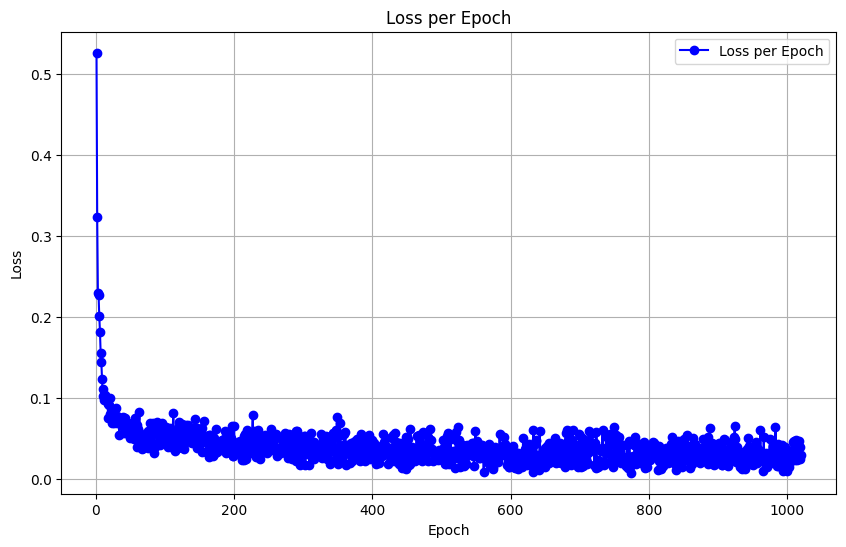

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_epochs) + 1)
#ff opletten dat dit dus eigenlijk loss per batch is, niet per epoch
# (kunnen nog ff andere plot maken waar we alle batches eerst optellen, is makkelijk te doen ipc)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_epochs, marker='o', linestyle='-', color='b', label='Loss per Epoch (train)')
#plt.plot(epochs, test_loss_epochs, marker='o', linestyle='-', color='r', label='Loss per Epoch (test)')
plt.title('Loss per batch (train)')
plt.xlabel('batch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()
epcohs = range(1, len(test_loss_epochs))
plt.figure(figsize=(10, 6))
#plt.plot(epochs, train_loss_epochs, marker='o', linestyle='-', color='b', label='Loss per Epoch (train)')
plt.plot(epochs, test_loss_epochs, marker='o', linestyle='-', color='r', label='Loss per Epoch (test)')
plt.title('Loss per Epoch (test)')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

# Normaliseren
Had geen effect voor mij

In [ ]:
import cv2
import numpy as np
import os

def compute_channelwise_mean_std(source_folder):
    # Accumulators for each channel
    channel_sums = np.zeros(3)
    channel_sums_sq = np.zeros(3)
    num_pixels = 0

    for filename in os.listdir(source_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = cv2.imread(os.path.join(source_folder, filename))
            num_pixels += image.shape[0] * image.shape[1]

            for i in range(3):  # Loop through channels
                channel_data = image[:, :, i].astype('float32')
                channel_sums[i] += np.sum(channel_data)
                channel_sums_sq[i] += np.sum(np.square(channel_data))

    means = channel_sums / num_pixels
    stds = np.sqrt(channel_sums_sq / num_pixels - np.square(means))
    stds[stds == 0] = 1e-6  # Prevent division by zero

    return means, stds

def normalize_images(source_folder, target_folder, means, stds):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for filename in os.listdir(source_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(source_folder, filename)
            image = cv2.imread(file_path).astype('float32')

            for i in range(3):  # Loop through channels
                # Subtract the mean and divide by the standard deviation
                image[:, :, i] = (image[:, :, i] - means[i]) / stds[i]

            # Normalize to 0-255
            min_val, max_val = image.min(), image.max()
            if min_val == max_val:
                image.fill(127.5)  # Handle the case where the image has zero variance
            else:
                image = 255 * (image - min_val) / (max_val - min_val)

            image = np.clip(image, 0, 255).astype('uint8')

            cv2.imwrite(os.path.join(target_folder, filename), image)

    print("Normalization complete. Normalized images are saved in", target_folder)

# Example usage
source_folder = "/content/reference"
target_folder = "/content/ref_norm"
grayscale = False
means, stds = compute_channelwise_mean_std(source_folder)
print('means: ', means)
print('stds: ', stds)
means = [132.24416005, 124.67951712,  74.47884891]
stds = [58.92333127, 54.13693165, 62.41253828]
normalize_images(source_folder, target_folder, means, stds)


"""
for raw_norm:
means:  [132.24416005 124.67951712  74.47884891]
stds:  [58.92333127 54.13693165 62.41253828]

for ref_norm
means:  [123.33504373 118.36575917  89.48706184]
stds:  [64.92975802 60.97702477 65.90736228]
"""

means:  [123.33504373 118.36575917  89.48706184]
stds:  [64.92975802 60.97702477 65.90736228]
Normalization complete. Normalized images are saved in /content/ref_norm


'\nfor raw_norm:\nmeans:  [132.24416005 124.67951712  74.47884891]\nstds:  [58.92333127 54.13693165 62.41253828]\n\nfor ref_norm\nmeans:  [123.33504373 118.36575917  89.48706184]\nstds:  [64.92975802 60.97702477 65.90736228]\n'

# Reset van cache

In [ ]:
torch.cuda.empty_cache() # dit als je cache vol is doen

# Evaluate and visualise

Deze werkt alleen als je een .pth file hebt

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f'Using device: {device}')

input_folder = '/content/raw'
reference_folder = '/content/reference'

raw_orig_dataset, raw_wb_dataset, raw_clahe_dataset, reference_tensor_dataset = create_tensor_datasets(input_folder, reference_folder, verbose=True)
model_eval = MFEFModule().to(device)
model_eval.load_state_dict(torch.load('/content/model_epoch_5_batch_10_batchsize_16.pth')) #hier de best getrainde inzetten

model_eval.eval()
with torch.no_grad():
    for img_tensor, wb_tensor, clahe_tensor, ref_tensor in zip(raw_orig_dataset, raw_wb_dataset, raw_clahe_dataset, reference_tensor_dataset):
        img_tensor, wb_tensor, clahe_tensor, ref_tensor = img_tensor.to(device), wb_tensor.to(device), clahe_tensor.to(device), ref_tensor.to(device)
        output = model_eval(img_tensor, wb_tensor, clahe_tensor)

        fig, axes = plt.subplots(1, 3, figsize=(12, 6))
        axes[0].imshow(transforms.ToPILImage()(img_tensor))
        axes[0].set_title("Raw Image")
        axes[0].axis('off')

        axes[1].imshow(transforms.ToPILImage()(ref_tensor))
        axes[1].set_title("Reference Image")
        axes[1].axis('off')

        axes[2].imshow(transforms.ToPILImage()(output[[2, 0, 1], :, :]))
        axes[2].set_title("Output Image")
        axes[2].axis('off')

        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import cv2
import numpy as np

def compute_global_mean_std(image_paths):
    """
    Compute the global mean and standard deviation for a dataset of images.

    Parameters:
    image_paths (list): A list of paths to the images.

    Returns:
    tuple: A tuple containing two lists - the global mean and the global standard deviation
           for each channel in the BGR format.
    """
    mean_sum = np.zeros(3)  # Initialize sum of means for B, G, R
    std_sum = np.zeros(3)   # Initialize sum of stds for B, G, R
    n_images = len(image_paths)

    for path in image_paths:
        image = cv2.imread(path)
        if image is not None:
            # Compute mean and std for each image and sum up
            mean_sum += np.mean(image, axis=(0, 1))
            std_sum += np.std(image, axis=(0, 1))

    # Calculate global mean and std by dividing by the number of images
    global_mean = mean_sum / n_images
    global_std = std_sum / n_images

    return global_mean.tolist(), global_std.tolist()

file_names = sorted(f for f in os.listdir(input_folder) if f.endswith('.png'))
all_images = []

for file_name in file_names:
  raw_path = os.path.join(input_folder, file_name)
  reference_path = os.path.join(reference_folder, file_name)
  all_images.append(raw_path)
  all_images.append(reference_path)

compute_global_mean_std(all_images)

([123.31657387292599, 119.02616341500875, 73.45408306597031],
 [49.882526548861804, 46.51649407446035, 46.464761191923365])

In [ ]:
def normalize_image(image, global_mean=[123.31657387292599, 119.02616341500875, 73.45408306597031], global_std=[49.882526548861804, 46.51649407446035, 46.464761191923365]):
    """
    Normalize a single image.

    Parameters:
    image (numpy.ndarray): A single image as a numpy array (H, W, C).
    global_mean (list or numpy.ndarray): The global mean for each channel.
    global_std (list or numpy.ndarray): The global standard deviation for each channel.

    Returns:
    numpy.ndarray: The normalized image.
    """
    # Ensure the mean and std are arrays to allow broadcasting
    global_mean = np.array(global_mean)
    global_std = np.array(global_std)
    # print('size img b4 norm ', image.shape)
    # Normalize the image
    normalized_image = (image - global_mean) / global_std
    # print('size img after norm ', normalized_image.shape)
    return normalized_image